In [1]:
!pip install netCDF4
!pip install keras-rectified-adam
import itertools

from scipy import linalg
import matplotlib.pyplot as plt 
import matplotlib as mpl

%load_ext tensorboard

import netCDF4
from netCDF4 import Dataset
import pathlib


import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Dropout, Reshape 
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from keras_radam import RAdam

import xarray as xr

from datetime import date
import datetime

     |████████████████████████████████| 4.1MB 2.9MB/s 
     |████████████████████████████████| 317kB 50.9MB/s 
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=ed54c565029d5d715ef67cfa913cf8f3cebb07608c62302934db76e1a0e9dbc7
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


Using TensorFlow backend.


In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import mixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Load the dataset (2004 period)



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [105]:
ds = xr.open_dataset("/content/gdrive/My Drive/dataset/SST_SSH_U_V_SLA_global_2004.nc")
print(ds.sizes)
ds

Frozen(SortedKeysDict({'lon': 1440, 'lat': 720, 'time': 366}))


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 366)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 1981-01-01
Data variables:
    SST      (time, lat, lon) float32 ...
    SSH      (time, lon, lat) float32 ...
    U        (time, lon, lat) float32 ...
    V        (time, lon, lat) float32 ...
    SLA      (time, lon, lat) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.5.3 (http://code...
    Conventions:            CF-1.0
    history:                Mon Jul 21 17:26:58 2014: cdo merge SST_SSH_U_V_g...
    title:                  Analysed foundation sea surface temperature, global
    DSD_entry_id:           REMSS-L4LRfnd-GLOB-tmi_amsre_OI
    references:             none
    source_data:            TMI-REMSS,AMSRE-REMSS
    contact:                support@remss.com
    GDS_version_id:         GDS-v1.0-rev1.6
    netcdf_version_id:      3.5.0
    creation_date:          2010-08-04
    product_version:        v03
    spatial_resolution:     25 km
    start_date:             2003-12-30
    start_time:             00:00:00 UTC
    stop_date:              2004-01-03
    stop_time:              23:59:59 UTC
    southernmost_latitude:  -89.875
    northernmost_latitude:  89.875
    westernmost_longitude:  -179.875
    easternmost_longitude:  179.875
    file_quality_index:     1
    comment:                www.remss.com for more infomation on product
    CDO:                    Climate Data Operators version 1.5.3 (http://code...

Print SSH

<xarray.DataArray 'SSH' (time: 230, lat: 72, lon: 48)>
[794880 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 30.125 30.375 30.625 30.875 ... 41.375 41.625 41.875
  * lat      (lat) float32 -47.875 -47.625 -47.375 ... -30.625 -30.375 -30.125
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 2004-08-17T12:00:00
Attributes:
    long_name:        H
    units:            cm
    _CoordinateAxes:  time NbLongitudes NbLatitudes

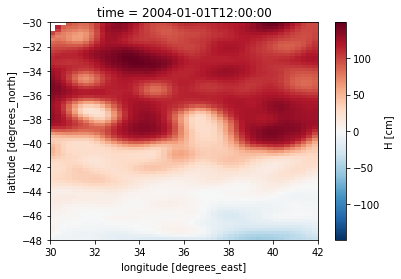

In [106]:
time_window = 230

ds_cut = ds.sel(lon=slice(30,42),lat=slice(-48,-30))
ds_cut = ds_cut.isel(time=slice(0,time_window))
SSH = ds_cut.SSH.transpose('time','lat','lon')
SSH[0].plot()
SSH

Print SST

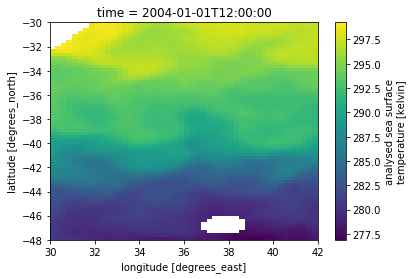

In [107]:
SST = ds_cut.SST
SST[0].plot()

Print current

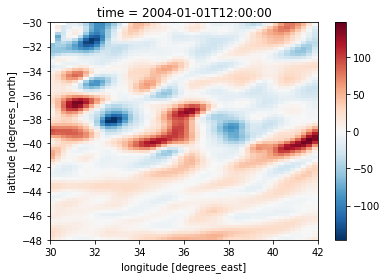

In [108]:
U = ds_cut.U.transpose('time','lat','lon')
V = ds_cut.V.transpose('time','lat','lon')
UV = U + V
UV[0].plot()

Compute min and max for all variable for normalization

In [109]:
df = ds_cut.to_dataframe()
SST_x_max = df.SST.describe(include='all').loc['max']
SST_x_min = df.SST.describe(include='all').loc['min']
SSH_x_max = df.SSH.describe(include='all').loc['max']
SSH_x_min = df.SSH.describe(include='all').loc['min']
U_x_max = df.U.describe(include='all').loc['max']
U_x_min = df.U.describe(include='all').loc['min']
V_x_max = df.V.describe(include='all').loc['max']
V_x_min = df.V.describe(include='all').loc['min']
df.describe()

,SST,SSH,U,V,SLA
count,776250.000000,793730.000000,792810.000000,792810.000000,794880.000000
mean,289.194275,67.750809,5.971282,0.518709,5.566825
std,6.360530,54.216053,23.332226,24.456177,18.605196
min,274.500000,-62.506332,-128.419235,-156.930954,-87.530159
25%,283.049988,13.110857,-5.437643,-7.530150,-2.750525
50%,291.449982,83.126221,4.391558,1.037214,4.094619
75%,294.600006,116.979446,15.411711,9.929499,12.704281
max,302.100006,202.495773,149.775803,131.770523,89.636559


In [110]:
for v in ds_cut.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       SST: analysed sea surface temperature
       SSH: H
         U: U
         V: V
       SLA: H


#Generate patchs

In [0]:
def pad_with(vector, pad_width, iaxis, kwargs):
  pad_value = kwargs.get('padder', 10)
  vector[:pad_width[0]] = pad_value
  vector[-pad_width[1]:] = pad_value

def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return 2*normalized_input - 1  

In [112]:
from sklearn.feature_extraction import image
patch_size_x = 8
patch_size_y = 8
padding = 4
nb_patch = SST.shape[1]*SST.shape[2]
print("NB PATCH : " + str(nb_patch))


# Create the array that contains all the SSH, SST, U, V patchs, dim: 1D
SST_patches = np.empty(([time_window, nb_patch, patch_size_x*patch_size_y]))

#fill NaN values with the mean of the SSH, SST, U, V mean
SSTf = SST.fillna(SST.mean())
SSTf = np.pad(SSTf, padding, pad_with, padder=SSTf.mean())
print('SSTf shape: {}'.format(SSTf.shape))


SSHf = SSH.fillna(SSH.mean())
print('SSH shape: {}'.format(SSH.shape))

Uf = U.fillna(U.mean())
print('U shape: {}'.format(U.shape))

Vf = V.fillna(V.mean())
print('V shape: {}'.format(V.shape))

SSH_n = np.empty(([time_window, 72,48]))
U_n = np.empty(([time_window, 72,48]))
V_n = np.empty(([time_window, 72,48]))

#for each time step, compute patches of size (13x13), flatten them in 1D and concatenate them in SSH_patches, SST_patches, U_patches, V_patches
#output : 1D array of SSH patchs
for i in range(ds_cut.time.shape[0]):
  if (i%50 == 0):
    print("Round : "+ str(i))
  
  patchesT = image.extract_patches_2d(SSTf[i], (patch_size_x, patch_size_y), max_patches = nb_patch-1, random_state=0) 
  #print(" SST_patches shape " + str(SST_patches.shape) )


  SST_p = np.empty(([patch_size_x*patch_size_y]))

  
  #print(SSH.shape[0])
  #for h in range(SSH[0].shape[0]):
  SSH_n[i] = (SSHf[i] - SSH_x_min)/(SSH_x_max-SSH_x_min)
  U_n[i] = (Uf[i] - U_x_min)/(U_x_max-U_x_min)
  V_n[i] = (Vf[i] - V_x_min)/(V_x_max-V_x_min)

  # for each patch generated, flatten the patch in 1D and stack it
  for j in range(patchesT.shape[0]):
    norm_p = (patchesT[j] - SST_x_min)/(SST_x_max-SST_x_min)
    flatt = norm_p.flatten()
    SST_p = np.vstack((SST_p,flatt))

  #print("SST " + str(SST_patches[i].shape))
  #print("p " + str(SST_p.shape))
  SST_patches[i] = SST_p

print('Patches shape: {}'.format(SST_patches.shape))


NB PATCH : 3456
SSTf shape: (238, 80, 56)
SSH shape: (230, 72, 48)
U shape: (230, 72, 48)
V shape: (230, 72, 48)
Round : 0
Round : 50
Round : 100
Round : 150
Round : 200
Patches shape: (230, 3456, 64)


Print SST patch

[0.69565135 0.69565135 0.69021678 0.68478221 0.67934769 0.67934769
 0.67391312 0.6630429  0.701087   0.69565135 0.69021678 0.68478221
 0.68478221 0.67934769 0.67391312 0.6630429  0.701087   0.69565135
 0.69021678 0.68478221 0.68478221 0.68478221 0.66847748 0.6630429
 0.70652157 0.69565135 0.69021678 0.69565135 0.69021678 0.69021678
 0.68478221 0.67934769 0.70652157 0.701087   0.701087   0.70652157
 0.70652157 0.70652157 0.70652157 0.69021678 0.71195614 0.70652157
 0.71195614 0.71739072 0.71739072 0.71739072 0.70652157 0.701087
 0.70652157 0.71195614 0.72282529 0.71739072 0.71739072 0.71739072
 0.71739072 0.71195614 0.70652157 0.71195614 0.71195614 0.71195614
 0.70652157 0.71195614 0.71739072 0.71739072]


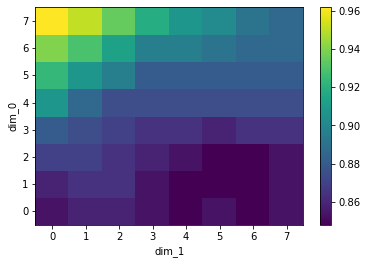

In [113]:
print(SST_patches[190,12])
rs = np.reshape(SST_patches[65,12], (8,8))
xr_SST = xr.DataArray(rs)
xr_SST.plot()

In [114]:
print(U_n[0])

[[0.51532358 0.4911837  0.47216555 ... 0.50105041 0.51752645 0.53486234]
 [0.50985378 0.48773357 0.47459432 ... 0.50606221 0.5154112  0.52557033]
 [0.4873243  0.47919881 0.47615692 ... 0.52012742 0.52238053 0.52608317]
 ...
 [0.48307988 0.4625113  0.4246487  ... 0.48661163 0.46211392 0.44488329]
 [0.48307988 0.47784409 0.43814573 ... 0.50110513 0.47143841 0.45164925]
 [0.48307988 0.48307988 0.48307988 ... 0.51930428 0.49581298 0.48090813]]


## II - Training of the compMLP

#Description of the model

In [0]:
class comp_MLP :
  def __init__(self, number_mode, X_train, y_train, X_test, y_test):
    self.number_mode = number_mode
    self.X_train = X_train[0]
    self.y_input = X_train[1]
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.comp_mlp = Sequential()

  def train(self):   
    #set early stopping monitor so the model stops training when it won't improve anymore
    early_stopping_monitor = EarlyStopping(patience=5)
    #train model
    print(self.X_train.shape)
    print("y_train : " + str(np.expand_dims(self.y_train, 0).shape))
    history = self.comp_mlp.fit([self.X_train,self.y_input], self.y_train, epochs=10, batch_size=1, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])
    print('\nhistory dict:', history.history)

  def create_model(self):
    #for i in range(1, self.number_mode)

    #get shape of the training data for the input layer initialization
    input_shape = self.X_train[0].shape
    X_train = tf.convert_to_tensor(self.X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(self.y_train, dtype=tf.float32)

    print("INPUT SHAPE : " + str(input_shape))

    # Define the layers of the model
    inp = Input(input_shape)
    
    self.comp_mlp.add(Dense(3, input_shape=input_shape))
    """self.comp_mlp.add(Dense(50, activation='relu'))
    self.comp_mlp.add(Dense(3))"""
    self.comp_mlp.summary()
    
    # Generate the 4 MLP
    mlp_out_1 = self.comp_mlp(inp)
    mlp_out_2 = self.comp_mlp(inp)
    mlp_out_3 = self.comp_mlp(inp)
    mlp_out_4 = self.comp_mlp(inp)

    #Input of the prediction
    input_y_shape = self.y_input[0].shape
    print("Y INPUT : "+ str(input_y_shape))
    #y_input = Input(input_y_shape)

    inp_y = Input(input_y_shape)

    print(inp_y.shape)
    print(mlp_out_1.shape)
    # Add a customized layer to compute the weight of each mode
    W1 = tf.keras.backend.exp(tf.math.scalar_mul(-1/2,tf.math.square(tf.math.scalar_mul(tf.math.reduce_std(mlp_out_1), layers.subtract([inp_y, mlp_out_1])))))
    W2 = tf.keras.backend.exp(tf.math.scalar_mul(-1/2,tf.math.square(tf.math.scalar_mul(tf.math.reduce_std(mlp_out_2), layers.subtract([inp_y, mlp_out_2])))))
    W3 = tf.keras.backend.exp(tf.math.scalar_mul(-1/2,tf.math.square(tf.math.scalar_mul(tf.math.reduce_std(mlp_out_3), layers.subtract([inp_y, mlp_out_3])))))
    W4 = tf.keras.backend.exp(tf.math.scalar_mul(-1/2,tf.math.square(tf.math.scalar_mul(tf.math.reduce_std(mlp_out_4), layers.subtract([inp_y, mlp_out_4])))))
    


    print("MLP OUTPUT : " + str(mlp_out_1.shape))
    print("W1 : " + str(W1.shape))
    #NEED TO REPLICATE THE WEIGHT FROM Kx1 TO Kx3
    partial_pred_1 = layers.multiply([mlp_out_1, W1])
    partial_pred_2 = layers.multiply([mlp_out_2, W2])
    partial_pred_3 = layers.multiply([mlp_out_3, W3])
    partial_pred_4 = layers.multiply([mlp_out_4, W4])
    print("partial pred layer : " + str(partial_pred_4))

    Y_pred_layer =  Lambda(lambda tensors: tf.math.add_n([tensors[0], tensors[1], tensors[2], tensors[3]]))
    Y_pred = Y_pred_layer([partial_pred_1, partial_pred_2, partial_pred_3, partial_pred_4 ])
    
    # Connect the input with the output
    self.comp_mlp = Model(inputs=[inp, inp_y],outputs=Y_pred)
    print("Y PRED SHAPE : " + str(Y_pred))

    #compile model using mse as a measure of model performance (add a custom loss function soon)
    self.comp_mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    """log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)"""


  def eval_test(self):
    print('\n# Evaluate on test data')
    results = self.comp_mlp.evaluate([self.X_test,self.y_test], self.y_test, batch_size=1)
    print('test loss, test acc:', results)


  def predict(self):
    print(self.X_test.shape)
    test_y_predictions = self.comp_mlp.predict([np.expand_dims(self.X_test[0],0),np.expand_dims(self.y_test[0],0)], batch_size=1)
    #test_y_predictions = self.comp_mlp.predict_on_batch([np.expand_dims(self.X_train[65],0),np.expand_dims(self.y_train[65],0)])
    print(test_y_predictions.shape)
    return test_y_predictions

In [123]:

#X = np.stack((SST_patches,SSH, U, V))
X= SST_patches
print(X[0].shape)



print("U : " + str(U_n.shape))
print("V : " + str(V_n.shape))
print("SSH : " + str(SSH_n.shape))
y = np.stack((SSH_n, U_n, V_n)) 
y_nb_feature = y.shape[0]
#print magique
print(SST.shape[2])

y = y.reshape((time_window, SST.shape[1]*SST.shape[2],y_nb_feature))
print("Y shape :" + str(y.shape))
# Split the data into training/testing sets
X_train = X[:190]
X_test = X[-40:]

# Split the targets into training/testing sets
y_train = y[:190]
y_test = y[-40:]

print("X_train : " + str(X_train.shape))
print("y_train : " + str(y_train.shape))
print("X_test : " + str(X_test.shape))
print("y_test : " + str(y_test.shape))
input_shape = (X_train.shape[1],)
print(input_shape)

#create model
modelCMLP = comp_MLP(4,[X_train,y_train],y_train, X_test, y_test)

modelCMLP.create_model()

modelCMLP.train()

#modelCMLP.predict()


(3456, 64)
U : (230, 72, 48)
V : (230, 72, 48)
SSH : (230, 72, 48)
48
Y shape :(230, 3456, 3)
X_train : (190, 3456, 64)
y_train : (190, 3456, 3)
X_test : (40, 3456, 64)
y_test : (40, 3456, 3)
(3456,)
INPUT SHAPE : (3456, 64)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 3456, 3)           195       
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________
Y INPUT : (3456, 3)
(?, 3456, 3)
(?, 3456, 3)
MLP OUTPUT : (?, 3456, 3)
W1 : (?, 3456, 3)
partial pred layer : Tensor("multiply_43/mul:0", shape=(?, 3456, 3), dtype=float32)
Y PRED SHAPE : Tensor("lambda_10/AddN:0", shape=(?, 3456, 3), dtype=float32)
(190, 3456, 64)
y_train : (1, 190, 3456, 3)
Train on 152 samples, validate on 38 samples
Epoch 1/10
152/152 [==============================] - 2s 11ms/sample - loss: 0.3737 

In [124]:
modelCMLP.eval_test()


# Evaluate on test data
40/40 [==============================] - 0s 4ms/sample - loss: 0.0211 - acc: 0.3342
test loss, test acc: [0.02113925330340862, 0.3342231]


In [125]:
res = modelCMLP.predict()

(40, 3456, 64)
(1, 3456, 3)


Print test prediction

[0.42029712 0.55153006 0.36215806]
toto
[0.64025623 0.62830454 0.60901588]
<xarray.DataArray (dim_0: 72, dim_1: 48)>
array([[0.6741844 , 0.4818246 , 0.4798232 , ..., 0.4338515 , 0.5140157 ,
        0.30904666],
       [0.50350493, 0.46840215, 0.31680125, ..., 0.4762085 , 0.45721132,
        0.3983007 ],
       [0.51204395, 0.44367436, 0.46618998, ..., 0.50912946, 0.58487695,
        0.44743523],
       ...,
       [0.5356887 , 0.5943293 , 0.59625036, ..., 0.4570113 , 0.48434412,
        0.56899685],
       [0.50498295, 0.44760364, 0.49305514, ..., 0.45495442, 0.50450873,
        0.45077986],
       [0.52200204, 0.41371343, 0.5299538 , ..., 0.47238874, 0.45735222,
        0.4690058 ]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1


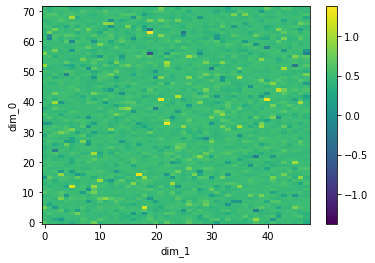

In [126]:
#res_renorm = res*(SSH_x_max-SSH_x_min) + SSH_x_min
print(res[0][10])
print("toto")
print(y_test[0][10])
r_res = np.reshape(res[0],(72,48,3))
xres = xr.DataArray(r_res)
print(xres[:,:,0])
#xres[:,0].plot()
xres[:,:,0].plot(cmap='viridis')

Print Test ground truth

[[0.20488459 0.21537806 0.22216143 ... 0.08285134 0.08879992 0.08927141]
 [0.23128782 0.23374639 0.23445816 ... 0.09609351 0.10282854 0.10290411]
 [0.24387787 0.24213637 0.23869437 ... 0.12218087 0.12251884 0.12152429]
 ...
 [0.49152902 0.5952388  0.55862844 ... 0.65803242 0.64722663 0.62434614]
 [0.49152902 0.61928612 0.55700409 ... 0.65564287 0.63889414 0.61387557]
 [0.49152902 0.49152902 0.49152902 ... 0.66002512 0.6402052  0.61628222]]


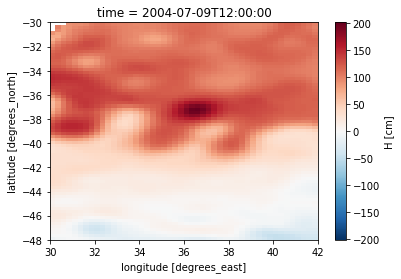

In [127]:
SSH[190].plot()
print(SSH_n[190])

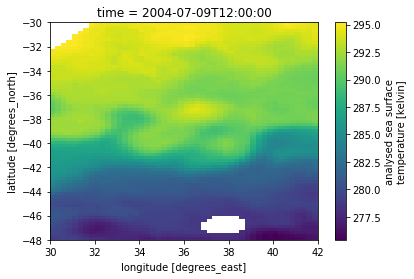

In [128]:
SST[190].plot()